# How often are language settings used?

*Megan Neisler*
<br />
*Last Update: March 1, 2021*

[Task](https://phabricator.wikimedia.org/T273986)

# Goal

We would like to determine the priority of displaying the cog which opens language settings across all pages by answering the following questions:

1. [What is the frequency of usage of the language settings cog?](#1.-What-is-the-frequency-of-usage-of-the-language-settings-cog?)
2. [What is the frequency of usage of any of the options provided after selecting the cog?](#2.-What-is-the-frequency-of-usage-of-any-of-the-options-provided-after-selecting-the-cog?)
3. [Compare the above with switching languages using the interlanguage links](#3.-Compare-the-above-with-switching-languages-using-the-interlanguage-links)


# Methodology

Data reflects events logged in the [UniversalLanguageSelector](https://meta.wikimedia.org/wiki/Schema:UniversalLanguageSelector) schema from January through February 2021. I reviewed events by logged-in users and logged-out sessions (Instrumentation tracks events for users as indicated by their user name or session token for logged-out users).

Relevant event instrumentation:

**ULS setting open**: action: "settings-open", context: "interlanguage"

**Display Language Switch**: action: "language-change"; context: "interface"

**Input Language Switch**: action: "ime-change"; inputMethod: "system"

**Font Language Switch**: action: "font-change"; context: "interface"



In [236]:
 shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(glue); library(lubridate); library(scales)
})

# 1. What is the frequency of usage of the language settings cog?

The language settings panel is the main entry point to configure language tools. It can be accessed from the cog show near the inter-language list on the sidebar, or at the personal toolbar for wikis lacking inter-language links.

I reviewed the number of events and users of the language settings cog and compared usage to other available methods for opening the langauge settings (such as, opening in personal tools, input tools pop up menu and spaecial preferences)

In [379]:
# review all settings open events
query <- "
SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) as uls_dt,
    event.token as uls_user,
    -- review different types of methods for opening ULS settings
    CASE
        WHEN (event.context = 'interlanguage') THEN 'cog_trigger'
        WHEN (event.context = 'personal') THEN 'personal_tools' 
        WHEN (event.context = 'menu') THEN 'input_tools_popup' 
        ELSE 'special_pref_link'
        END AS uls_settings_opened_by,
    COUNT(*) AS num_open_events
FROM 
    event.universallanguageselector
WHERE
     -- remove bots
    useragent.is_bot = false 
    AND year = 2021
    AND event.action = 'settings-open'
GROUP BY
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    event.token,
    CASE WHEN (event.context = 'interlanguage') THEN 'cog_trigger'
        WHEN (event.context = 'personal') THEN 'personal_tools' 
        WHEN (event.context = 'menu') THEN 'input_tools_popup' 
        ELSE 'special_pref_link'
        END
"

In [380]:
collect_uls_open_events <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [381]:
collect_uls_open_events$uls_dt <- as.Date(collect_uls_open_events$uls_dt, format = "%Y-%m-%d")

In [382]:
# add logged in status columen
# anon users identified by token = session token

collect_uls_open_events$logged_in_status <- ifelse(str_detect(collect_uls_open_events$uls_user, 
                                                              "^[a-f0-9]{20}$"), 'logged-out session', 'logged-in user')

## Average number of language cog settings events per user

In [383]:
lang_settings_open_avg_peruser <- collect_uls_open_events %>%
    group_by(uls_settings_opened_by, logged_in_status) %>%
    summarise(avg_events = round(mean(num_open_events),2))

lang_settings_open_avg_peruser 

`summarise()` regrouping output by 'uls_settings_opened_by' (override with `.groups` argument)



uls_settings_opened_by,logged_in_status,avg_events
<chr>,<chr>,<dbl>
cog_trigger,logged-in user,1.67
cog_trigger,logged-out session,1.18
personal_tools,logged-in user,1.88
personal_tools,logged-out session,1.45
special_pref_link,logged-in user,1.36


The language settings cog is used an average 1.7 times per logged-in user and 1.2 times per logged-out session by users that click the language cog at least once. Compariatively, the uls trigger accessed by opening personal tools had a slightly higer average user per user.

## Number of language setting open events by open method

In [386]:
## Number of ULS cog open events vs other open events
lang_settings_open_events <- collect_uls_open_events %>%
    mutate(total_events = sum(num_open_events)) %>%
    group_by( uls_settings_opened_by) %>%
    summarise(num_events = sum(num_open_events),
             pct_all_events = round(num_events/total_events, 4) * 100) %>%
    distinct()

lang_settings_open_events

`summarise()` regrouping output by 'uls_settings_opened_by' (override with `.groups` argument)



uls_settings_opened_by,num_events,pct_all_events
<chr>,<int>,<dbl>
cog_trigger,1349312,92.74
personal_tools,105161,7.23
special_pref_link,442,0.03


## Number of language setting open events by open method and logged in status

In [389]:
## Number of ULS cog open events vs other open events
lang_settings_open_events_byanon <- collect_uls_open_events %>%
    group_by(logged_in_status) %>%
    mutate(total_events = sum(num_open_events)) %>%
    group_by( uls_settings_opened_by, logged_in_status) %>%
    summarise(num_events = sum(num_open_events),
             pct_all_events = round(num_events/total_events, 4) * 100) %>%
    arrange(logged_in_status) %>%
    distinct()

lang_settings_open_events_byanon

`summarise()` regrouping output by 'uls_settings_opened_by', 'logged_in_status' (override with `.groups` argument)



uls_settings_opened_by,logged_in_status,num_events,pct_all_events
<chr>,<chr>,<int>,<dbl>
cog_trigger,logged-in user,58525,64.18
personal_tools,logged-in user,32226,35.34
special_pref_link,logged-in user,442,0.48
cog_trigger,logged-out session,1290787,94.65
personal_tools,logged-out session,72935,5.35


The vast majority of events (92.7% [1,349,312 events])  to open the language settings are clicks to the language setting cogs. This includes both logged-in and logged out users.

A breakdown by logged-in status shows that 64.8% [58,525 events] of lang setting open events from logged-in users and 94.7% [1,290,787 of events] of lang setting open events by logged-out users were clicks to the language setting cog. 

No logged out or logged in users opened the language settings using the input tools popup menu.


## Number of distinct users that opened language settings by open method

In [391]:
## Number of distinct UlS settings Users vs All Other Distinct Users logged in ULS
lang_settings_all_users <- collect_uls_open_events %>%
    group_by(logged_in_status) %>%
    mutate(total_users = n_distinct(uls_user)) %>%
    ungroup()  %>%
    group_by(logged_in_status, uls_settings_opened_by) %>%
    summarise(num_users = n_distinct(uls_user),
             pct_all_users = round(num_users/total_users, 4) * 100) %>%
    distinct()

lang_settings_all_users

`summarise()` regrouping output by 'logged_in_status', 'uls_settings_opened_by' (override with `.groups` argument)



logged_in_status,uls_settings_opened_by,num_users,pct_all_users
<chr>,<chr>,<int>,<dbl>
logged-in user,cog_trigger,29578,71.54
logged-in user,personal_tools,13843,33.48
logged-in user,special_pref_link,312,0.75
logged-out session,cog_trigger,1087759,95.60
logged-out session,personal_tools,50012,4.40


When accessing the language settings, 71.5% [29578 distinct users] of logged-in users used the cog in the sidebar. 33.5% of logged-in users opened the language settings using the uls trigger in personal tools and only 0.75% used the link in Special:Preference language selection.

The majority (95.6% [1,087,759 logged-out sessios]) of all logged-out sessions opened the language settings using the cog. The remaining 4.4% of logged-out sessions opened language settings using the uls trigger in personal tools

No users opened the language settings using the input tools popup menu.

## Daily Number of Language Setting Open Distinct Users

In [91]:
options(repr.plot.width = 15, repr.plot.height = 10)

`summarise()` regrouping output by 'uls_dt' (override with `.groups` argument)



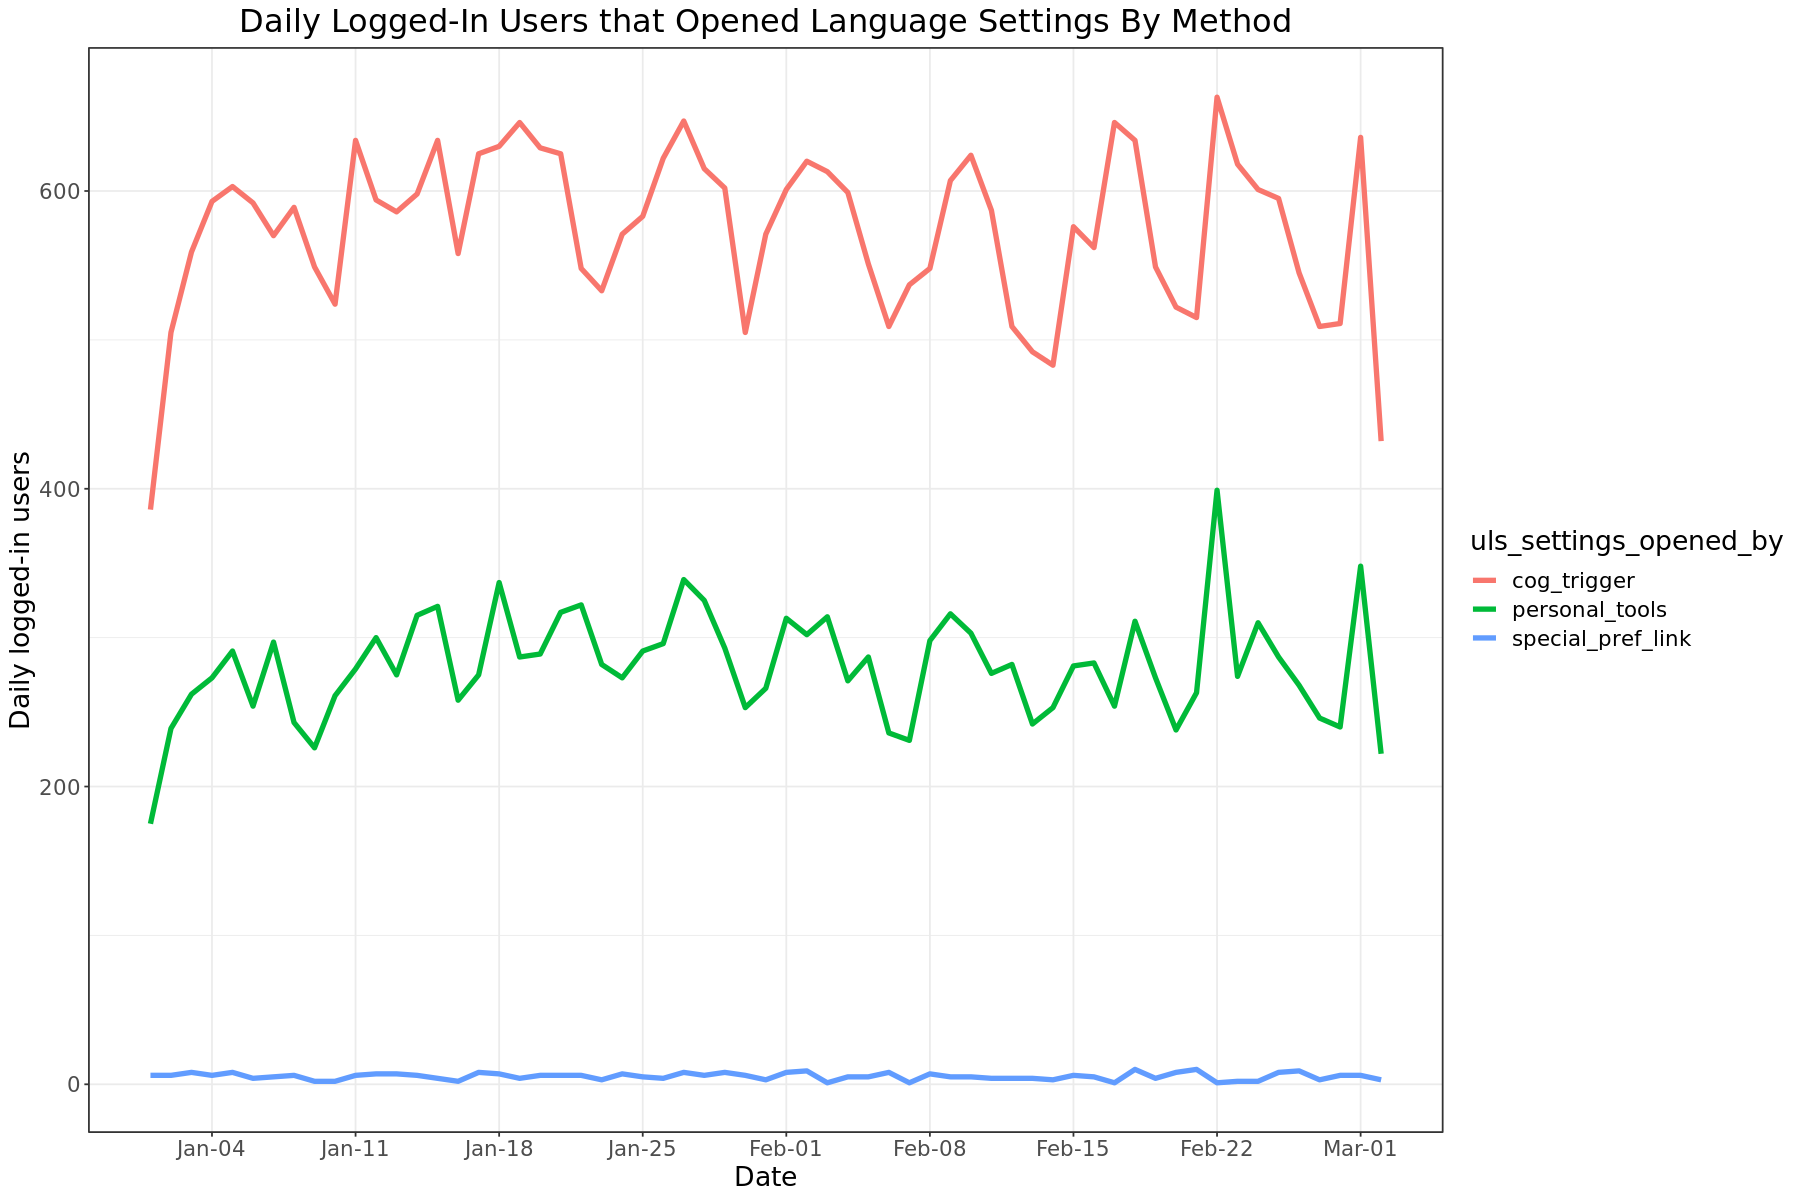

In [393]:
# Look at daily number of logged in users that click setting-open
lang_settings_open_daily_users <- collect_uls_open_events %>%
    filter(logged_in_status != 'logged-out session') %>%
    group_by(uls_dt,  uls_settings_opened_by) %>%
    summarise(num_users = n_distinct(uls_user)) %>%
    ggplot(aes(x= uls_dt, y = num_users, color =  uls_settings_opened_by)) +
    geom_line(size = 1.5) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 week", minor_breaks = NULL) +
    scale_y_continuous(labels = polloi::compress) +
    labs (y = "Daily logged-in users",
              x = "Date",
             title = "Daily Logged-In Users that Opened Language Settings By Method")  +
        theme_bw() +
        scale_fill_brewer(name="Search Location", palette="Set1")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "right")
      
lang_settings_open_daily_users

`summarise()` regrouping output by 'uls_dt' (override with `.groups` argument)



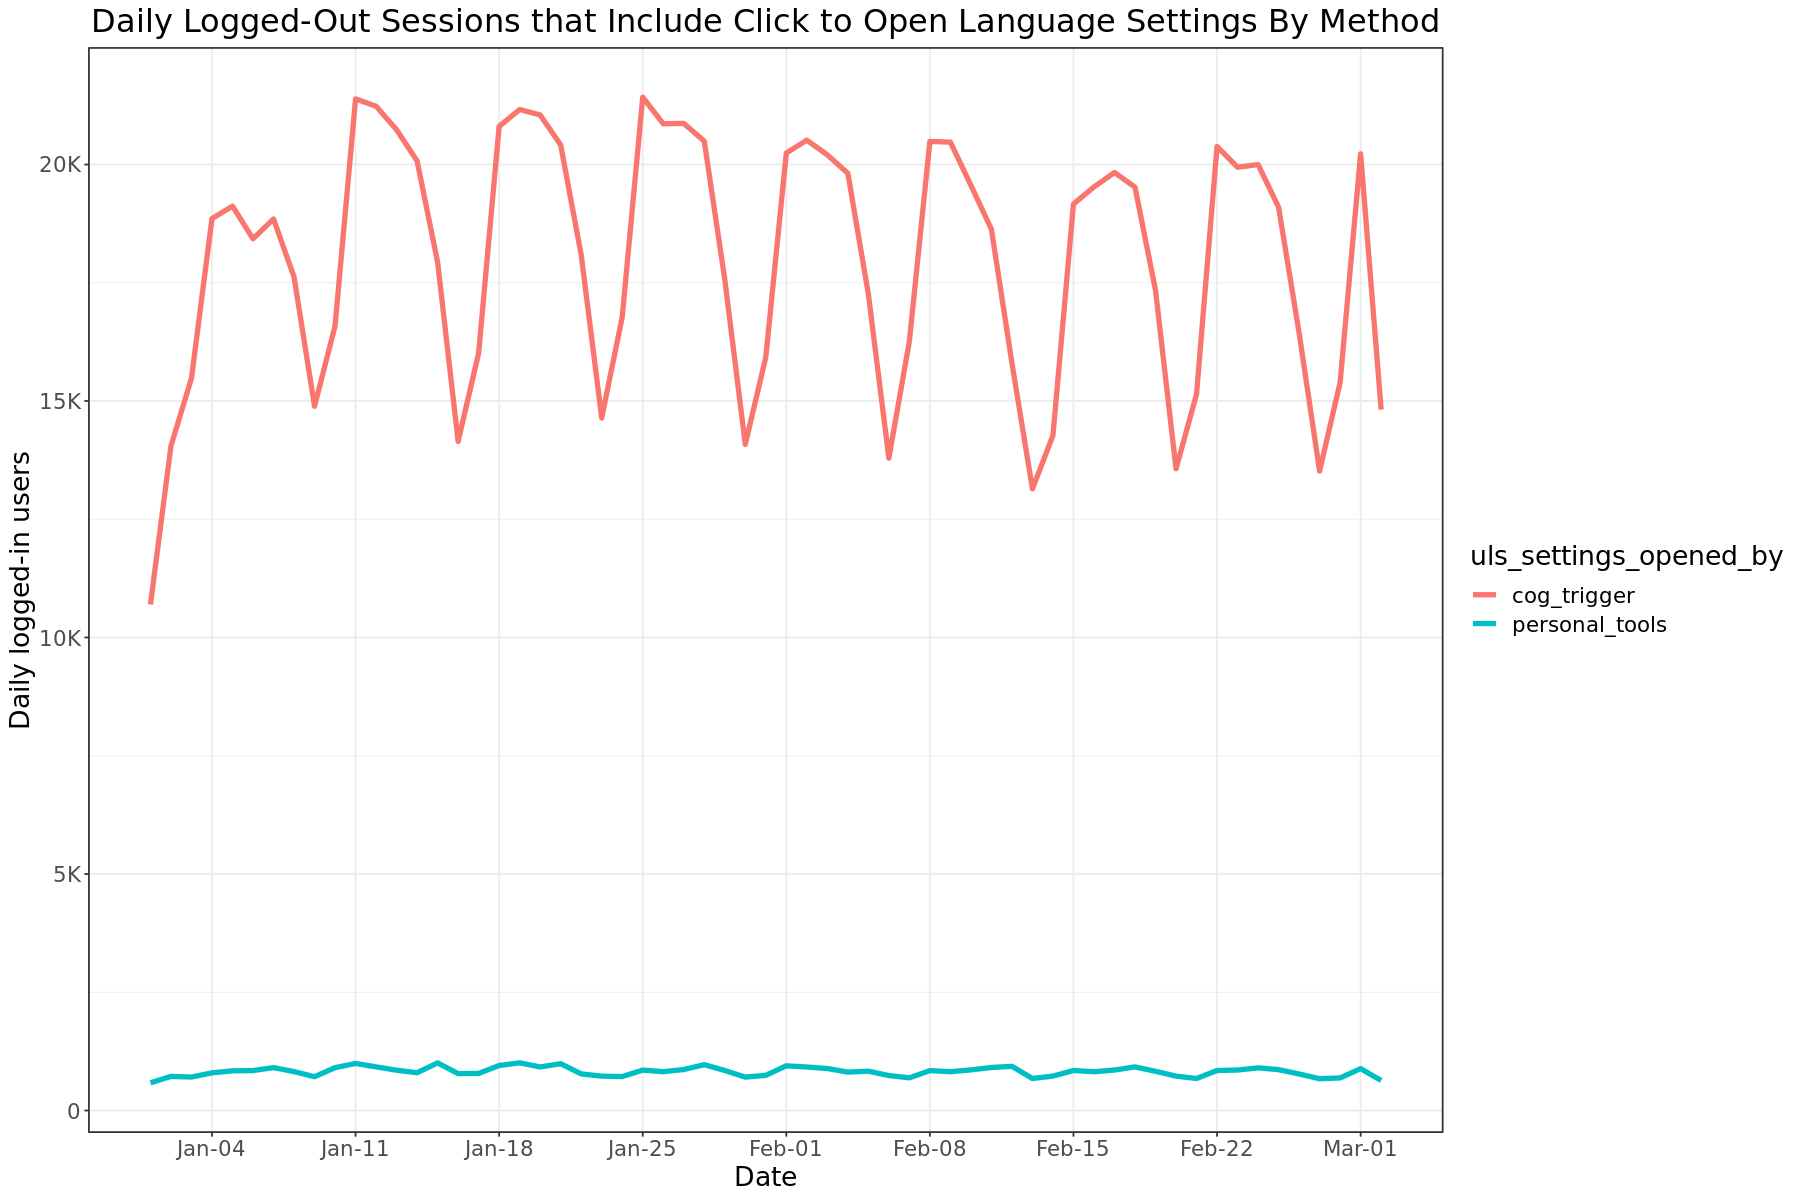

In [394]:
# Look at daily number of logged out sessions that click setting-open
lang_settings_open_daily_anonsessions <- collect_uls_open_events %>%
    filter(logged_in_status == 'logged-out session',
          uls_settings_opened_by != 'not_settings_open_event') %>%
    group_by(uls_dt,  uls_settings_opened_by) %>%
    summarise(num_users = n_distinct(uls_user)) %>%
    ggplot(aes(x= uls_dt, y = num_users, color =  uls_settings_opened_by)) +
    geom_line(size = 1.5) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 week", minor_breaks = NULL) +
    scale_y_continuous(labels = polloi::compress) +
    labs (y = "Daily logged-in users",
              x = "Date",
             title = "Daily Logged-Out Sessions that Include Click to Open Language Settings By Method")  +
        theme_bw() +
        scale_fill_brewer(name="Search Location", palette="Set1")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "right")
      
lang_settings_open_daily_anonsessions

In [395]:
lang_settings_open_daily_users_averages <- collect_uls_open_events %>%
    group_by(uls_dt,  uls_settings_opened_by, logged_in_status) %>%
    summarise(num_users = n_distinct(uls_user)) %>%
    ungroup() %>%
    group_by(uls_settings_opened_by, logged_in_status) %>%
    summarise(avg_daily_users = mean(num_users))

lang_settings_open_daily_users_averages 

`summarise()` regrouping output by 'uls_dt', 'uls_settings_opened_by' (override with `.groups` argument)

`summarise()` regrouping output by 'uls_settings_opened_by' (override with `.groups` argument)



uls_settings_opened_by,logged_in_status,avg_daily_users
<chr>,<chr>,<dbl>
cog_trigger,logged-in user,574.098361
cog_trigger,logged-out session,17944.377049
personal_tools,logged-in user,280.901639
personal_tools,logged-out session,824.278689
special_pref_link,logged-in user,5.327869


The cog trigger is consitently the most used method to open language settings compared to other available methods for both logged-in and logged-out users.

Across all wiki projects, an average of about 574 distinct logged-in users per day click the language settings cog. For logged-out users, an average of 17,944 distinct logged out sessions per day include a click the language settings cog.

# 2. What is the frequency of usage of any of the options provided after selecting the cog?

In [397]:
query <- "
--find all users that selected a cog to open language settings
WITH uls_setting_users AS (
SELECT
 event.token as uls_user
FROM 
    event.universallanguageselector
WHERE
    event.action = 'settings-open'
    AND event.context = 'interlanguage'
     -- remove bots
    AND useragent.is_bot = false 
    AND year = 2021
)
--Main Query--

SELECT
    event.token as uls_user,
    -- review different types of ULS options
    SUM(CAST(event.action = 'language-change' AND event.context = 'interface' AS INT)) AS display_change,
    SUM(CAST (event.action = 'ime-change' AND event.inputMethod = 'system' AS INT )) AS input_change,
    SUM(CAST (event.action = 'font-change' AND event.context = 'interface' AS INT))  AS font_change,
    COUNT(*) AS n_all_events
FROM 
    event.universallanguageselector
INNER JOIN uls_setting_users
     ON event.token = uls_setting_users.uls_user
WHERE
     -- remove bots
    useragent.is_bot = false 
    AND year = 2021
GROUP BY
     event.token
"

In [398]:
collect_uls_option_events <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [399]:
# add logged in status columen
# anon users identified by token = session token

collect_uls_option_events$logged_in_status <- ifelse(str_detect(collect_uls_option_events$uls_user, 
                                                              "^[a-f0-9]{20}$"), 'logged-out session', 'logged-in user')

In [400]:
# clean up table
uls_option_events <- collect_uls_option_events %>%
  gather("change_type", "num_events", 2:4)


## Number of display, font, and input change events

In [401]:

settings_change_option_byevent <- uls_option_events %>%
    group_by(logged_in_status, change_type) %>%
    summarise(num_change_events =sum(num_events),
              num_all_events = sum(n_all_events),
             pct_all_events = round(num_change_events/num_all_events,4) * 100) 

settings_change_option_byevent

`summarise()` regrouping output by 'logged_in_status' (override with `.groups` argument)



logged_in_status,change_type,num_change_events,num_all_events,pct_all_events
<chr>,<chr>,<int>,<int>,<dbl>
logged-in user,display_change,109918,907199,12.12
logged-in user,font_change,2225,907199,0.25
logged-in user,input_change,25383,907199,2.80
logged-out session,display_change,0,2574245,0.00
logged-out session,font_change,7918,2574245,0.31
logged-out session,input_change,140318,2574245,5.45


Only a small percent of all logged ULS events include changes to the settings options. 12.1 percent of all events logged by users that clicked the language settings cog were to change the display. 

Note: This also includes settings open events as well as other logged interactions from users that opened the language setting using the cog.

## Number and Percent of Distinct users that make change to display, font, and input options

In [402]:

settings_change_option_byuser <- collect_uls_option_events %>%
  gather("change_type", "num_events", 2:5)%>%
    group_by(logged_in_status) %>%
    mutate(total_users = n_distinct(uls_user)) %>%
    ungroup()  %>%
    filter(num_events != 0) %>%
    group_by(logged_in_status, change_type) %>%
    summarise(num_users = n_distinct(uls_user),
             pct_all_users = round(num_users/total_users,4) * 100) %>%
    distinct()

settings_change_option_byuser

`summarise()` regrouping output by 'logged_in_status', 'change_type' (override with `.groups` argument)



logged_in_status,change_type,num_users,pct_all_users
<chr>,<chr>,<int>,<dbl>
logged-in user,display_change,13624,46.06
logged-in user,font_change,229,0.77
logged-in user,input_change,3014,10.19
logged-in user,n_all_events,29578,100.00
logged-out session,font_change,2368,0.22
logged-out session,input_change,47564,4.37
logged-out session,n_all_events,1087759,100.00


After selecting the language settings cog, 46% of all logged-in users change the display language at least once. 10.2% of logged-in users change the input language and only 0.77% change the font at least once.

Display setting changes only available for logged-in users. Only 4.37% of logged-out sessions include a change to the input language and 0.22% to the font.


## Users Interactions with Language Setting Changes

The analysis below provides more detail regarding how each distinct user interfacts with the available langugage setting change options. In other words, what percent of users just change the display, just change the input, change multiple settings, or change none of the display, input or font settings after clicking on the cog.

In [403]:
query <- "
WITH uls_setting_users AS (
SELECT 
    DISTINCT event.token as uls_user
FROM 
    event.universallanguageselector
WHERE
    event.action = 'settings-open'
    AND event.context = 'interlanguage'
     -- remove bots
    AND useragent.is_bot = false 
    AND year = 2021
),

display_change_users AS (

SELECT 
    DISTINCT event.token as display_user
FROM 
    event.universallanguageselector
WHERE
    event.action = 'language-change' 
    AND event.context = 'interface'
     -- remove bots
    AND useragent.is_bot = false 
    AND year = 2021
),

input_change_users AS (

SELECT 
    DISTINCT event.token as input_user
FROM 
    event.universallanguageselector
WHERE
    event.action = 'ime-change' 
    AND event.inputMethod = 'system'
     -- remove bots
    AND useragent.is_bot = false 
    AND year = 2021
),

font_change_users AS (

SELECT 
    DISTINCT event.token as font_user
FROM 
    event.universallanguageselector
WHERE
    event.action = 'font-change' 
    AND event.context = 'interface'
     -- remove bots
    AND useragent.is_bot = false 
    AND year = 2021
)

--Main Query
SELECT
  uls_user,
-- review all primary possible ULS change selection options
   CASE
        WHEN (display_user IS NOT NULL AND input_user is NULL AND font_user IS NULL ) THEN 'display_change_user_only'
        WHEN (input_user IS NOT NULL AND display_user IS NULL and font_user IS NULL) THEN 'input_change_user_only'
        WHEN (font_user IS NOT NULL AND display_user IS NULL and input_user IS NULL) THEN 'font_change_user_only'
        WHEN (display_user IS NOT NULL AND input_user IS NOT NULL AND font_user IS NULL) THEN 'display_and_input_user'
        WHEN (display_user IS NOT NULL AND input_user IS NULL AND font_user IS NOT NULL) THEN 'display_and_font_user'
        WHEN (display_user IS NULL AND input_user IS NOT NULL AND font_user IS NOT NULL) THEN 'input_and_font_user'
        WHEN (display_user IS NOT NULL AND input_user IS NOT NULL AND font_user IS NOT NULL) THEN 'all_setting_change_user' 
        WHEN (display_user IS  NULL AND input_user IS  NULL AND font_user IS  NULL) THEN 'no_change_selected'
        ELSE 'NA'
        END AS uls_setting_change_type
FROM (
  SELECT
    uls_user AS uls_user,
    display_user AS display_user,
    input_user AS input_user,
    font_user AS font_user
  FROM uls_setting_users AS uls_setting_users
  LEFT JOIN display_change_users
  ON  uls_setting_users.uls_user = display_change_users.display_user
  LEFT JOIN input_change_users
  ON  uls_setting_users.uls_user = input_change_users.input_user
  LEFT JOIN font_change_users
  ON  uls_setting_users.uls_user = font_change_users.font_user
) langauge_change_selections

"

In [404]:
collect_uls_change_selections <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [405]:
# add logged in status column
# anon users identified by token = session token

collect_uls_change_selections$logged_in_status <- ifelse(str_detect(collect_uls_change_selections$uls_user, 
                                                              "^[a-f0-9]{20}$"), 'logged-out session', 'logged-in user')

In [406]:
# review uls setting changes by combination of options
uls_change_users <- collect_uls_change_selections %>%
     group_by(logged_in_status) %>%
      summarize(total_users = n_distinct(uls_user),
              display_change_only = sum(uls_setting_change_type== 'display_change_user_only'),
              input_change_only =sum(uls_setting_change_type== 'input_change_user_only'),
             font_change_only =sum(uls_setting_change_type== 'font_change_user_only'),
                display_and_input_change =sum(uls_setting_change_type== 'display_and_input_user'),
                display_and_font_change =sum(uls_setting_change_type== 'display_and_font_user'),
                input_and_font_change =sum(uls_setting_change_type== 'input_and_font_user'),
                all_settings_change =sum(uls_setting_change_type== 'all_setting_change_user'),
            no_change_selected =sum(uls_setting_change_type== 'no_change_selected')) %>%
        gather("change_type", "n_users", 3:10)%>%
        mutate(pct_users = round((n_users/total_users),4) * 100)   


`summarise()` ungrouping output (override with `.groups` argument)



In [407]:
## reorder columns to present numbers together
uls_change_users <- uls_change_users[c(3,1,4,2,5)]

uls_change_users

change_type,logged_in_status,n_users,total_users,pct_users
<chr>,<chr>,<int>,<int>,<dbl>
display_change_only,logged-in user,11421,29578,38.61
display_change_only,logged-out session,0,1087759,0.00
input_change_only,logged-in user,837,29578,2.83
input_change_only,logged-out session,46611,1087759,4.29
font_change_only,logged-in user,82,29578,0.28
font_change_only,logged-out session,1415,1087759,0.13
display_and_input_change,logged-in user,2093,29578,7.08
display_and_input_change,logged-out session,0,1087759,0.00
display_and_font_change,logged-in user,63,29578,0.21


Most logged-in users that click the language settings cog (38.61%) only make a change to the display setting. Only 7.1% of users make a change to both the display and input settings and 0.21% to the display and font settings.

50.7% of all logged-in users and 95.5% of all logged-out sessions are not recorded making any changes to the display, input, or font settings after selecting the cog. The users either selected the cog and did not make any changes (perhaps only exploring what it did) or could have been performing other changes provided by the settings menu including clicking the ("...") button to search for more languages but not ever making a change, or disabling or enabling the input method functionality. 

# 3. Compare the above with switching languages using the interlanguage links

I compared interactions with the ULS to switching languages using the interlanguage links in the sidebar. Data on the interlangauge usage comes from [wmf.interlaguage_navigation](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Interlanguage) derived from aggregated webrequest data. This schema does not include per user or per session basis but we can compare number of events to help get an idea of how frequently each is used during a similar time period.



In [344]:
# collect daily interlanguage events
query <-
"
SELECT 
    interlanguage_navigation.`date` AS dt,
    sum(navigation_count) AS num_events
FROM wmf.interlanguage_navigation
WHERE 
    interlanguage_navigation.`date` >= '2021-01-01' 
GROUP BY
       interlanguage_navigation.`date`
"

In [345]:
collect_interlanguage_selections <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [219]:
collect_interlanguage_selections$dt <- as.Date(collect_interlanguage_selections$dt, format = "%Y-%m-%d")

In [346]:
## add column to clarify type
collect_interlanguage_selections$event_type <- 'interlanguage'

In [409]:
# aggregate daily uls settings events to compate

uls_events_daily <- collect_uls_open_events %>%
# only review clicks to ULS settings cog events
     filter( uls_settings_opened_by != 'not_settings_open_event') %>%
    group_by(uls_dt) %>%
    summarise(num_events = sum(num_open_events))  %>%
    mutate(event_type = 'language settings')  %>%
    rename(dt = uls_dt)


`summarise()` ungrouping output (override with `.groups` argument)



In [356]:
## join the two tables together to compare
uls_vs_interlanguage <- rbind(uls_events_daily,collect_interlanguage_selections)

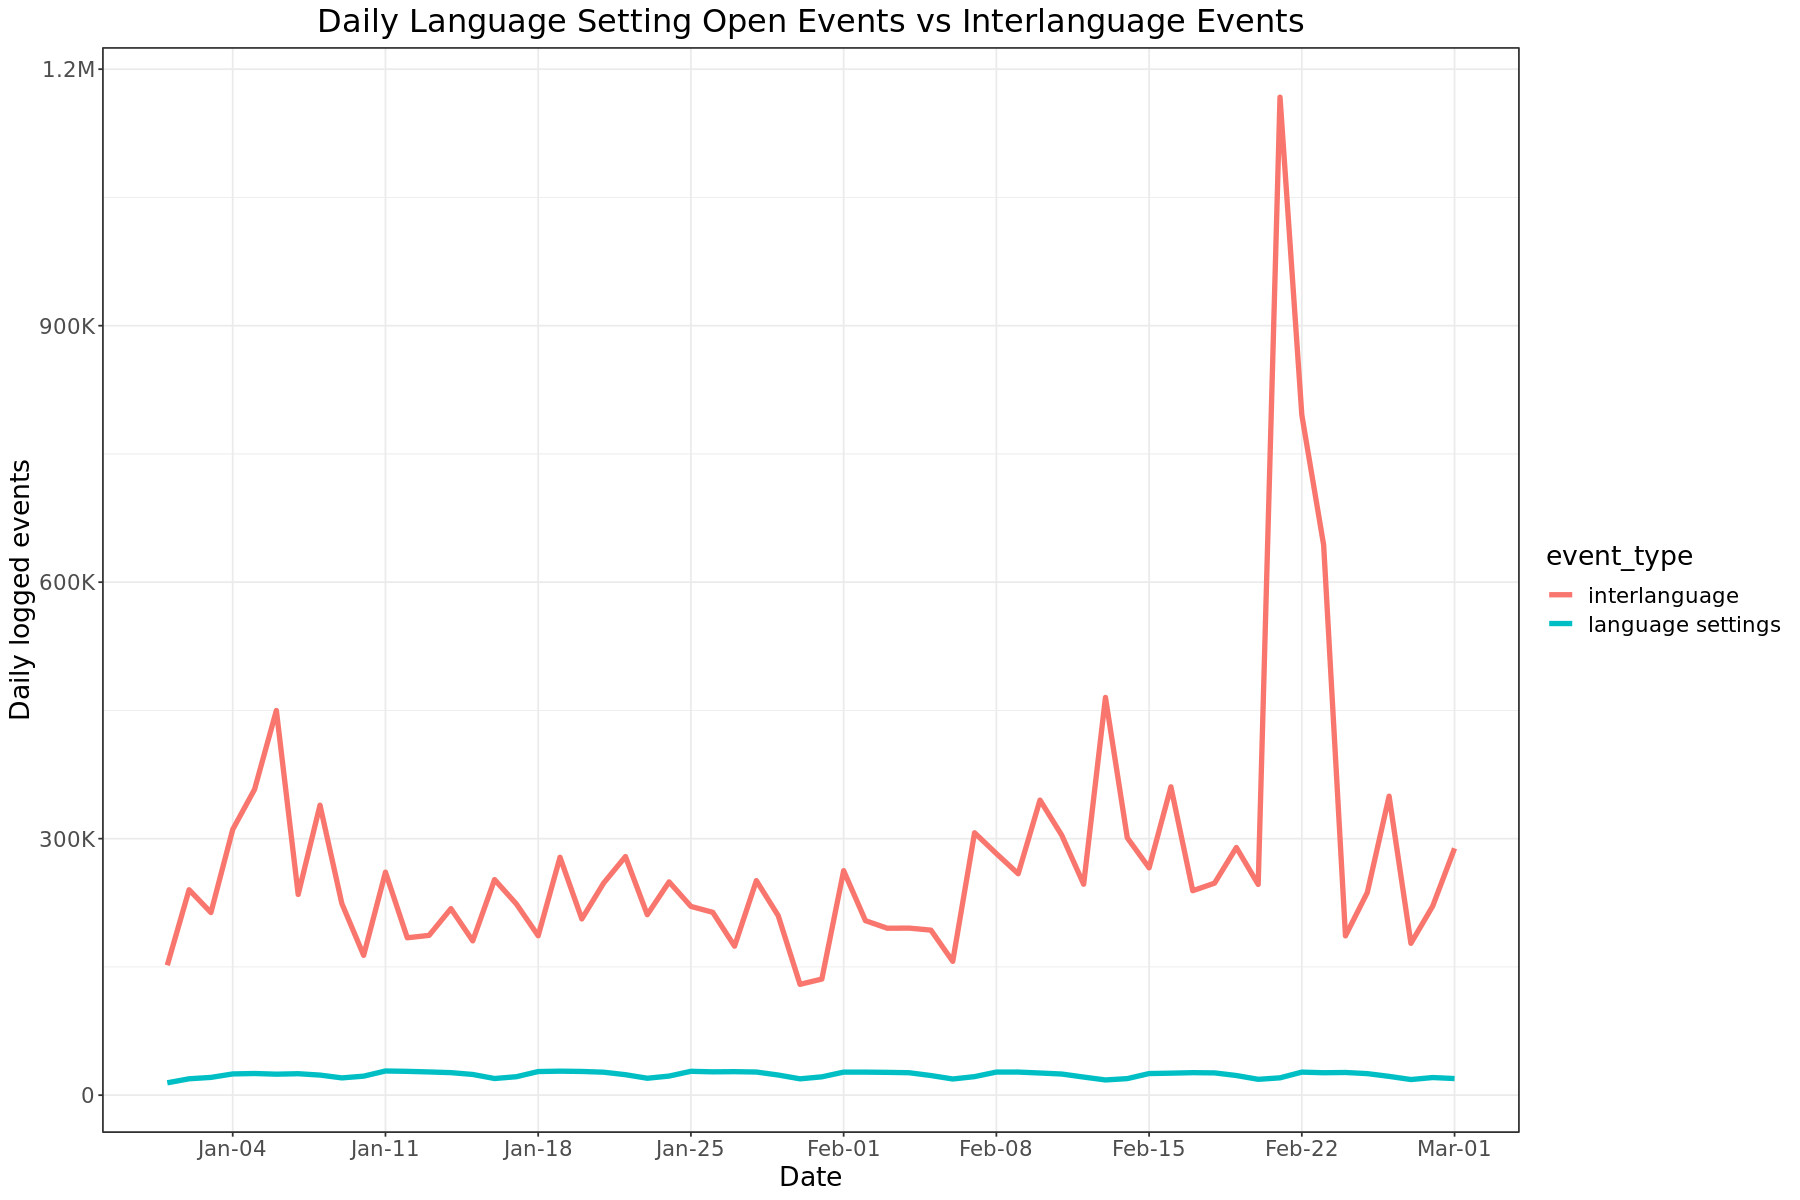

In [357]:


uls_vs_interlanguage_daily <- uls_vs_interlanguage %>%
    ggplot(aes(x= dt, y = num_events, color =  event_type)) +
    geom_line(size = 1.5) +
    scale_x_date(date_labels = "%b-%d", date_breaks = "1 week", minor_breaks = NULL) +
    scale_y_continuous(labels = polloi::compress) +
    labs (y = "Daily logged events",
              x = "Date",
             title = "Daily Language Setting Open Events vs Interlanguage Events")  +
        theme_bw() +
        scale_fill_brewer(name="Search Location", palette="Set1")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position = "right")

uls_vs_interlanguage_daily

In [358]:
## Compare the two totals

uls_vs_interlanguage_total <- uls_vs_interlanguage %>%
    group_by(event_type) %>%
    summarise(total_events = sum(num_events))

uls_vs_interlanguage_total

`summarise()` ungrouping output (override with `.groups` argument)



event_type,total_events
<chr>,<int>
interlanguage,16618768
language settings,1428218


The number of recorded language switching events (for example, coming from de.wikipedia.org and going to ro.wikipedia.org) far exceeds (over 11 times higher) than the number of clicks to open the language settings cog in the sidebar. 

There is an average of 276,979.5 language switches per day across all wiki projects, while there is an average of only 23,803.6 clicks to the language setting cog per day. 

